# **Irene Dovichi** 
## Midterm 1 - Assignment 5
Perform image segmentation on all images in the dataset, using the normalized cut algorithm running on the top of superpixels rather than on raw pixels. For each image compute an accuracy metric (which one it is up to you to decide) measuring the overlap between the segments identified by NCUT and the ground truth horse semantic segmentation. Provide a table summarizing the average segmentation accuracy on all images, plus present 2 examples of images that are well-segmented (according to the above defined metric).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color, graph, io
from skimage.metrics import structural_similarity
from skimage.filters import threshold_mean, threshold_otsu, threshold_yen
import os
import seaborn as sns
from tqdm import tqdm

## Dataset Loading
All the original images of the Weizmann Horse Database (link: www.kaggle.com/datasets/ztaihong/weizmann-horse-database/data) are saved in the list `images`. 

The corresponding masks are saved in the list `masks`.

In [2]:
path = './weizmann_horse_db/horse'
images = []
for file in sorted(os.listdir(path)):
    if os.path.isfile(os.path.join(path, file)):
        images.append(io.imread(os.path.join(path, file)))

In [3]:
path = './weizmann_horse_db/mask'
masks = []
for file in sorted(os.listdir(path)):
    if os.path.isfile(os.path.join(path, file)):
        masks.append(io.imread(os.path.join(path, file)))

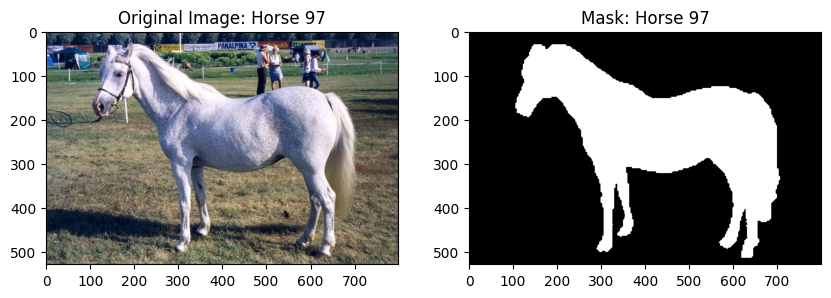

In [4]:
# print element m of `images` and the corresponding element of `masks`
m = 97

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(images[m])
plt.title(f'Original Image: Horse {m}')

plt.subplot(1, 2, 2)
plt.imshow(masks[m], cmap='gray')
plt.title(f'Mask: Horse {m}')
plt.show()

## Segmentation Grid Search
The skimage implementation of SLIC algorithm was used to generate the superpixels of images. The parameters I focused on were:
- `compactness`, for which I tried the values: 5, 10, 20
- `sigma`, for which I tried: 0, 1
- `n_segments`, for which I tried: 75, 100, 500

The best parameter configuration was chosen on the basis of the results obtained comparing the processed images and the masks.

I also tried the zero-parameter version SLICO.

In [4]:
# convert images to grayscale
gray_images = [color.rgb2gray(img) for img in images]

In [6]:
# compactness parameters
compactness = [5, 10, 20]

# sigma parameters
sigma = [0, 1]

# number of segments
n_segments = [75, 100, 500]

I performed the grid search on half of the instances of the dataset (randomly chosen), since it is time consuming.

In [7]:
len(images)

327

In [8]:
# select k random images 
k = 164
np.random.seed(42)
random_indexes = np.random.choice(len(images), k, replace=False)
random_images = []
gray_random_images = []
random_masks = []
for i in random_indexes:
    random_images.append(images[i])
    gray_random_images.append(gray_images[i])
    random_masks.append(masks[i])


Then, proceed to apply segmentation to the colored images for each parameter configuration.

In [9]:
segmentation_results = []

# apply segmentation and ncut
with tqdm(total=16*k, desc='loading', colour='yellow') as pbar:
    for i in range(len(random_images)): 
        image_results = []
        for c in compactness:
            for s in sigma:
                for n in n_segments:
                    # if c,s,n = 5,1,500 or 10,0,500 skip
                    if (c,s,n) == (5,1,500) or (c,s,n) == (10,0,500):
                        continue
                    segments = segmentation.slic(random_images[i], compactness=c, n_segments=n, sigma=s)
                    g = graph.rag_mean_color(random_images[i], segments, mode='similarity')
                    cut = graph.cut_normalized(segments, g)
                    # store results for this combination of parameters
                    image_results.append((c, s, n, segments, cut))
                    pbar.update(1)
        segmentation_results.append(image_results)

loading: 100%|██████████| 2624/2624 [50:58<00:00,  1.17s/it]  


In [10]:
# for example, the segmentation of the first image, for the first combination of parameters (c, s, n) is:
segmentation_results[0][0][3]

array([[ 1,  1,  1, ...,  8,  8,  8],
       [ 1,  1,  1, ...,  8,  8,  8],
       [ 1,  1,  1, ...,  8,  8,  8],
       ...,
       [51, 51, 51, ..., 50, 50, 50],
       [51, 51, 51, ..., 50, 50, 50],
       [51, 51, 51, ..., 50, 50, 50]])

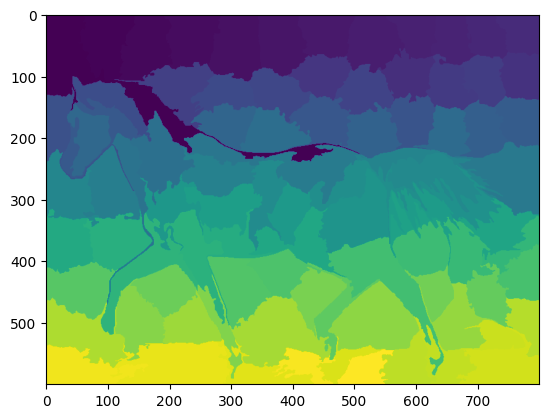

In [33]:
# for example, the plot of the segmentation of the eight image (of `random_images`), for the ninth combination of parameters (c, s, n) is:
plt.imshow(segmentation_results[7][8][3])

### Segmentation Accuracy

Now, let's compare the segmented regions obtained from normalized cut with ground truth segmentation masks so that we can choose the best configuration of parameters. 

The metrics tested are: 
- Intersection over Union 
- Structural Similarity Index Measure (SSIM)

The first one is defined as: $\small{IoU(A,B)} = \large{\frac{|A \cap B|}{|A \cup B|}}$, and has been implemented in the next cell. The second, instead, is available in `skimage.metrics`.

In [26]:
def IoU(segments, mask):
    intersection = np.logical_and(segments, mask)
    union = np.logical_or(segments, mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

Since the comparison is done with the masks, which have only 2 colors, I decided to reduce the cut to a 2-colors image. So, I converted the multi-class segmentation result into a binary mask by thresholding the pixel values. More precisely, I followed three steps:
1. the labels of segmentation were used to create a rgb image with each superpixel colored using the average color of its pixels 
2. the images obtained were converted to grayscale in order to have a uniform scale for all
3. a threshold was used to obtain binary images

For the step 3., I tried on some images the `skimage.filters` implementations of Otsu's method, Yen's method, and a method based on the mean of grayscale values. Then, I decided to use `threshold_mean` for all the images. 

Before applying these actions to all the `random_images`, let's see the result of each step for a chosen horse (the eight) and parameters configuration (the ninth).

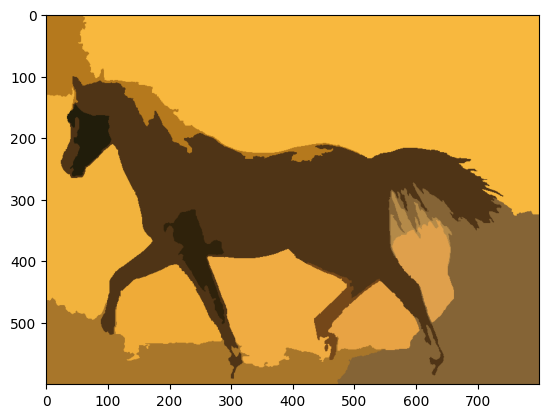

In [128]:
# step 1
ncolored = color.label2rgb(segmentation_results[7][8][4], random_images[7], kind='avg')
plt.imshow(ncolored)

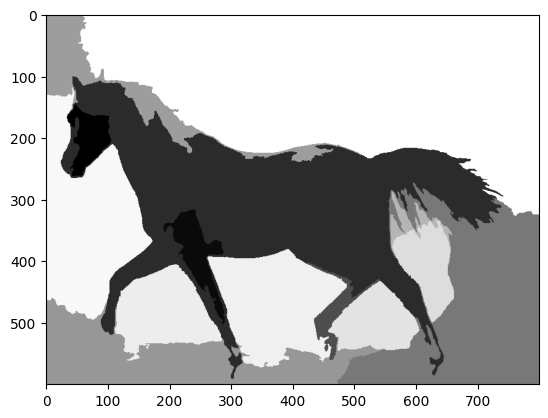

In [123]:
# step 2
gray_image = color.rgb2gray(ncolored)
plt.imshow(gray_image, cmap='gray')

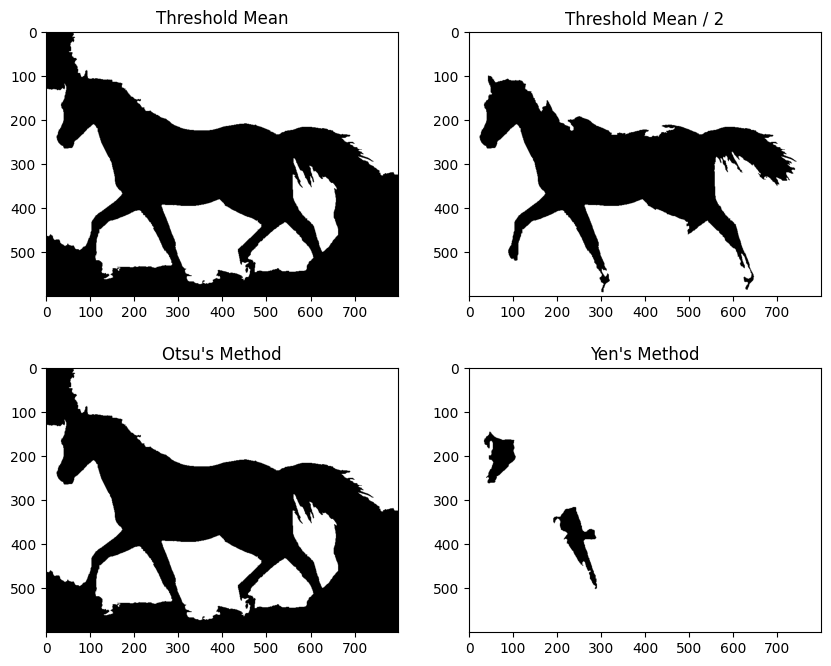

In [93]:
# step 3

# use threshold_mean to create a binary mask
thresh = threshold_mean(gray_image)
thresh_image = gray_image > thresh

# use threshold_mean divided by 2 to create a binary mask
thresh2 = threshold_mean(gray_image)/2
thresh_image2 = gray_image > thresh2

# use otsu's method
thresh_otsu = threshold_otsu(gray_image)
thresh_image_otsu = gray_image > thresh_otsu

# try yen's method
thresh_yen = threshold_yen(gray_image)
thresh_image_yen = gray_image > thresh_yen

# plot the masks
plt.figure(figsize=(10,8))
plt.subplot(2, 2, 1)
plt.imshow(thresh_image, cmap='gray')
plt.title('Threshold Mean')

plt.subplot(2, 2, 2)
plt.imshow(thresh_image2, cmap='gray')
plt.title('Threshold Mean / 2')

plt.subplot(2, 2, 3)
plt.imshow(thresh_image_otsu, cmap='gray')
plt.title("Otsu's Method")

plt.subplot(2, 2, 4)
plt.imshow(thresh_image_yen, cmap='gray')
plt.title("Yen's Method")
plt.show()

Finally, let's compute the two metrics on one of the 4 thresholded images and the ground truth mask.

Notice that: 
- I also considered `threshold_mean`/2 because, looking at the step 2. image, it was evident that there was some dark shadow which would have made it difficult to separate the silhouette of the horse from the background
- I chose the one obtained with `threshold_mean`/2 for this example because, to my eye, it's the most similar to the mask
- Both metrics are computed taking the maximum between the result obtained for the thresholded image and its inverse (1 - the image); in fact it could happen that the thresholded image has the horse in black and the background in white (exactly as happened for the eighth horse example above), while the masks have the horse in white and black background.

In [96]:
iou = max(IoU(thresh_image2, random_masks[7]), IoU(1-thresh_image2, random_masks[7]))
iou

0.8006614839061648

In [101]:
ssim = max(
    structural_similarity(thresh_image2, random_masks[7], data_range=1),
    structural_similarity(1-thresh_image2, random_masks[7], data_range=1)
    )
ssim

0.895240846968187

Now, we apply the presented actions to the `random_images` and calculate the two metrics for each configuration of parameters. I decided to try both the threshold mean and the threshold mean divided by 2.

In [104]:
# store in a dictionary the iou and ssim scores for each parameter combination using threshold_mean
iou_scores = {}
ssim_scores = {}

for config in range(len(segmentation_results[0])):
    iou_scores[config] = []
    ssim_scores[config] = []
    for i in range(len(random_images)):
        ncolored = color.label2rgb(segmentation_results[i][config][3], random_images[i], kind='avg')
        gray_image = color.rgb2gray(ncolored)
        thresh = threshold_mean(gray_image)
        thresh_image = gray_image > thresh
        iou = max(IoU(thresh_image, random_masks[i]), IoU(1-thresh_image, random_masks[i]))
        iou_scores[config].append(iou)
        ssim = max(
            structural_similarity(thresh_image, random_masks[i], data_range=1),
            structural_similarity(1-thresh_image, random_masks[i], data_range=1)
            )
        ssim_scores[config].append(ssim)

In [105]:
# store in a dictionary the iou and ssim scores for each parameter combination using threshold_mean/2
iou_scores2 = {}
ssim_scores2 = {}

for config in range(len(segmentation_results[0])):
    iou_scores2[config] = []
    ssim_scores2[config] = []
    for i in range(len(random_images)):
        ncolored = color.label2rgb(segmentation_results[i][config][3], random_images[i], kind='avg')
        gray_image = color.rgb2gray(ncolored)
        thresh = threshold_mean(gray_image)/2
        thresh_image = gray_image > thresh
        iou = max(IoU(thresh_image, random_masks[i]), IoU(1-thresh_image, random_masks[i]))
        iou_scores2[config].append(iou)
        ssim = max(
            structural_similarity(thresh_image, random_masks[i], data_range=1),
            structural_similarity(1-thresh_image, random_masks[i], data_range=1)
            )
        ssim_scores2[config].append(ssim)

In [110]:
# compute the mean iou and ssim scores for each parameter combination
mean_iou_scores = {}
mean_ssim_scores = {}
for config in range(len(segmentation_results[0])):
    mean_iou_scores[config] = np.mean(iou_scores[config])
    mean_ssim_scores[config] = np.mean(ssim_scores[config])

mean_iou_scores2 = {}
mean_ssim_scores2 = {}
for config in range(len(segmentation_results[0])):
    mean_iou_scores2[config] = np.mean(iou_scores2[config])
    mean_ssim_scores2[config] = np.mean(ssim_scores2[config])

In [116]:
# see the config corresponding to the max for the 4 dictionaries
print(f'Config with max IoU using threshold_mean: {max(mean_iou_scores, key=mean_iou_scores.get)}'
      f' with a score of {mean_iou_scores[max(mean_iou_scores, key=mean_iou_scores.get)]}')
print(f'Config with max SSIM using threshold_mean: {max(mean_ssim_scores, key=mean_ssim_scores.get)}'
        f' with a score of {mean_ssim_scores[max(mean_ssim_scores, key=mean_ssim_scores.get)]}')
print(f'Config with max IoU using threshold_mean/2: {max(mean_iou_scores2, key=mean_iou_scores2.get)}'
        f' with a score of {mean_iou_scores2[max(mean_iou_scores2, key=mean_iou_scores2.get)]}')
print(f'Config with max SSIM using threshold_mean/2: {max(mean_ssim_scores2, key=mean_ssim_scores2.get)}'
        f' with a score of {mean_ssim_scores2[max(mean_ssim_scores2, key=mean_ssim_scores2.get)]}')

Config with max IoU using threshold_mean: 12 with a score of 0.41290099584101636
Config with max SSIM using threshold_mean: 13 with a score of 0.6161164668701632
Config with max IoU using threshold_mean/2: 15 with a score of 0.4242547120992774
Config with max SSIM using threshold_mean/2: 13 with a score of 0.7162944734093615


We can notice that both using `threshold_mean` and `threshold_mean`/2, the best configuration is the fourteenth for the SSIM metric. However, the score is considerably higher if we divide by 2 threshold mean (from 0.616 to 0.716). On the other hand, the best score with respect to the IoU metric didn't change so much if we decreased the threshold, but the best configuration was different in the two cases. 

In conclusion: I decided to choose the fourteenth configuration, apply `threshold_mean`/2 to obtain my (binary) masks, and then evaluate the results with the SSIM metric.

In [126]:
# let's see which is the config 13
segmentation_results[0][13]

(20,
 1,
 75,
 array([[ 1,  1,  1, ..., 10, 10, 10],
        [ 1,  1,  1, ..., 10, 10, 10],
        [ 1,  1,  1, ..., 10, 10, 10],
        ...,
        [62, 62, 62, ..., 59, 59, 59],
        [62, 62, 62, ..., 59, 59, 59],
        [62, 62, 62, ..., 59, 59, 59]]),
 array([[ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        ...,
        [43, 43, 43, ..., 43, 43, 43],
        [43, 43, 43, ..., 43, 43, 43],
        [43, 43, 43, ..., 43, 43, 43]]))

## Segmentation with the winning configuration
In this section, I am going to apply to all the images of the dataset the SLIC algorithm for superpixel generation. The parameters that we are going to fix are: 
- `compactness` = 20
- `n_segments` = 75
- `sigma` = 1

Secondly, I consider the Region Adjacency Graph (RAG) using the labels obtained with the segmentation procedure. The chosen strategy to assign edge weights is `similarity` because the other option (`distance`) is problematic with `cut_normalized`, since it has minimum value in case of same color. Finally, I performed the normalized cut on the RAG.

In [4]:
# apply to all the images the best config
best_segmentations = []

# apply segmentation and ncut
with tqdm(total=len(images), desc='loading', colour='yellow') as pbar:
    for i in range(len(images)): 
        segments = segmentation.slic(images[i], compactness=20, n_segments=75, sigma=1)
        g = graph.rag_mean_color(images[i], segments, mode='similarity')
        cut = graph.cut_normalized(segments, g)
        # store results for this image
        best_segmentations.append((segments, cut))
        pbar.update(1)

loading: 100%|██████████| 327/327 [02:52<00:00,  1.89it/s]


In [5]:
# compute ssim score using threshold_mean/2 for all the images
ssim = []
for i in range(len(images)):
    ncolored = color.label2rgb(best_segmentations[i][0], images[i], kind='avg')
    gray_image = color.rgb2gray(ncolored)
    thresh = threshold_mean(gray_image)/2
    thresh_image = gray_image > thresh
    ssim_score = max(
        structural_similarity(thresh_image, masks[i], data_range=1),
        structural_similarity(1-thresh_image, masks[i], data_range=1)
        )
    ssim.append(ssim_score)

In [6]:
# print the mean, the lowest, and the highest ssim scores
print(f'Mean SSIM score: {np.mean(ssim)}')
print(f'Lowest SSIM score: {min(ssim)}')
print(f'Highest SSIM score: {max(ssim)}')

Mean SSIM score: 0.7074409621600245
Lowest SSIM score: 0.4171443600771757
Highest SSIM score: 0.9585141928148654


In [9]:
# get the indexes of the two lowest and two highest ssim scores
copy_ssim = ssim.copy()
copy_ssim.sort()
lowest = copy_ssim[:2]
highest = copy_ssim[-2:]

ssim.index(lowest[0]), ssim.index(lowest[1]), ssim.index(highest[0]), ssim.index(highest[1])

(11, 265, 124, 295)

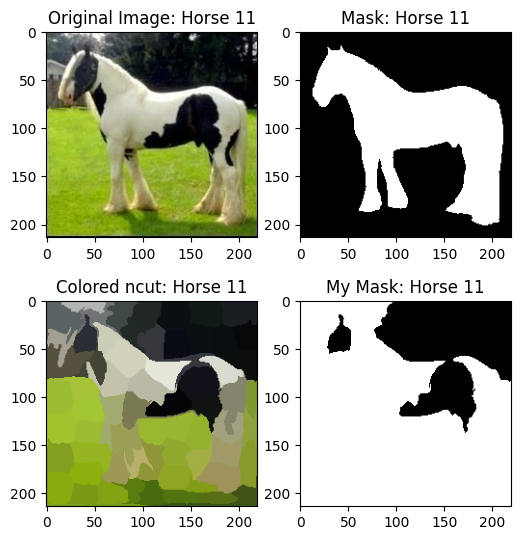

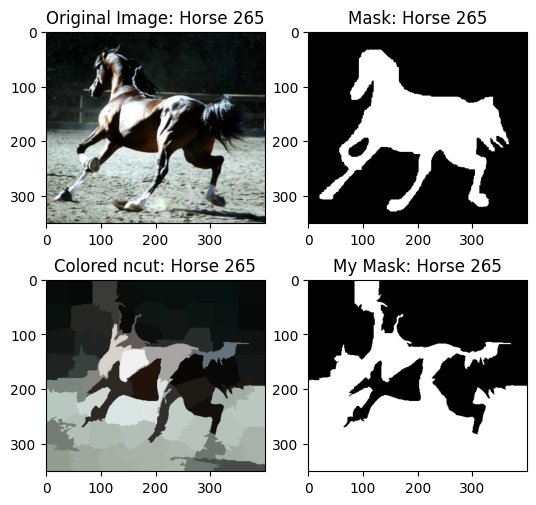

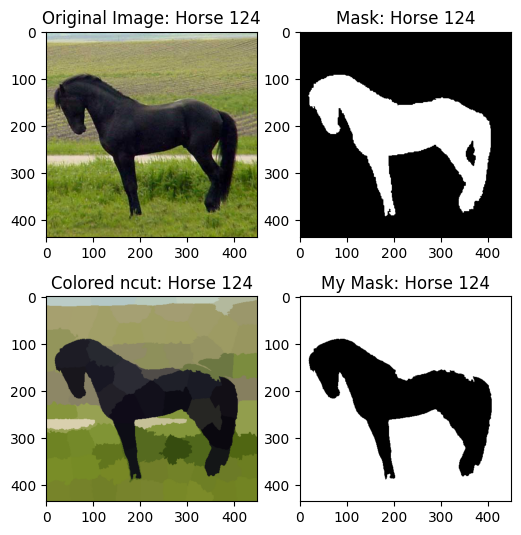

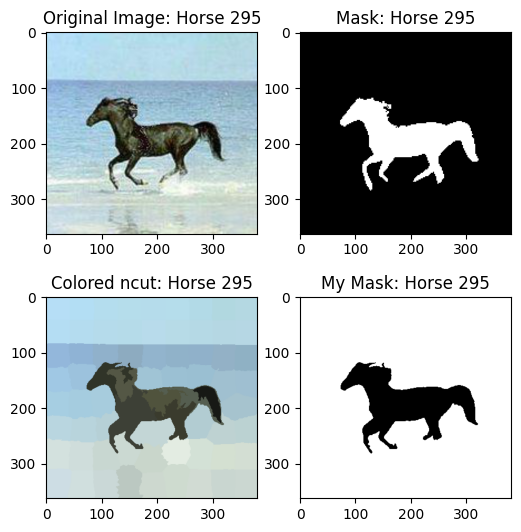

In [23]:
indexes = [ssim.index(lowest[0]), ssim.index(lowest[1]), ssim.index(highest[0]), ssim.index(highest[1])]

for i in indexes:
    if i == ssim.index(lowest[0]):
        plt.figure(figsize=(6,6.4))
    elif i == ssim.index(lowest[1]):
        plt.figure(figsize=(6.2, 5.9))
    else:
        plt.figure(figsize=(6,6.3))
    plt.subplot(2, 2, 1)
    plt.imshow(images[i])
    plt.title(f'Original Image: Horse {i}')

    plt.subplot(2, 2, 2)
    plt.imshow(masks[i], cmap='gray')
    plt.title(f'Mask: Horse {i}')

    ncolored = color.label2rgb(best_segmentations[i][0], images[i], kind='avg')
    gray_image = color.rgb2gray(ncolored)
    thresh = threshold_mean(gray_image)/2
    thresh_image = gray_image > thresh
        
    plt.subplot(2, 2, 3)
    plt.imshow(ncolored)
    plt.title(f'Colored ncut: Horse {i}')

    plt.subplot(2, 2, 4)
    plt.imshow(thresh_image, cmap='gray')
    plt.title(f'My Mask: Horse {i}')
    plt.show()

We can also visualize the general behavior of the SSIM plotting its histogram.

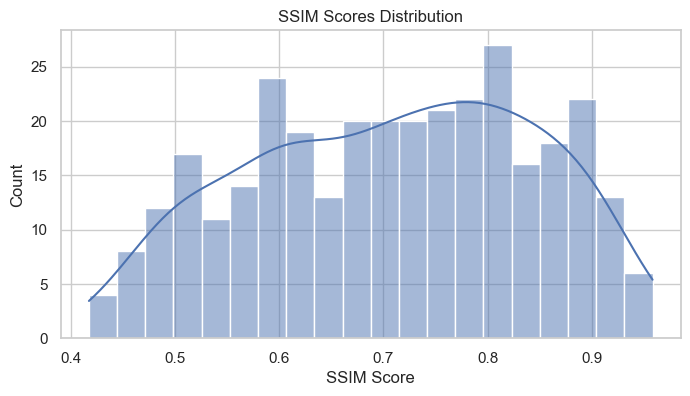

In [31]:
# plot the distribution of ssim scores also showing the mean, the lowest, and the highest scores
plt.figure(figsize=(8,4))
sns.histplot(ssim, kde=True, bins=20)
plt.title('SSIM Scores Distribution')
plt.xlabel('SSIM Score')
plt.ylabel('Count')
plt.show()

## Zero-parameters version: SLICO
Let's now try the version without parameters, so as to have a baseline with which to compare our model. SLICO adaptively chooses the compactness parameter for each superpixel differently, and this generates regular shaped superpixels both in textured and non-textured regions. 

Reference: https://www.epfl.ch/labs/ivrl/research/slic-superpixels/#SLICO

In [32]:
segmentation_results = []

# apply segmentation and ncut
with tqdm(total=len(images), desc='loading', colour='yellow') as pbar:
    for i in range(len(images)): 
        image_results = []
        segments = segmentation.slic(images[i], slic_zero=True)
        g = graph.rag_mean_color(images[i], segments, mode='similarity')
        cut = graph.cut_normalized(segments, g)
        # store results for this combination of parameters
        image_results.append((segments, cut))
        pbar.update(1)
        segmentation_results.append(image_results)

loading: 100%|██████████| 327/327 [03:32<00:00,  1.54it/s]


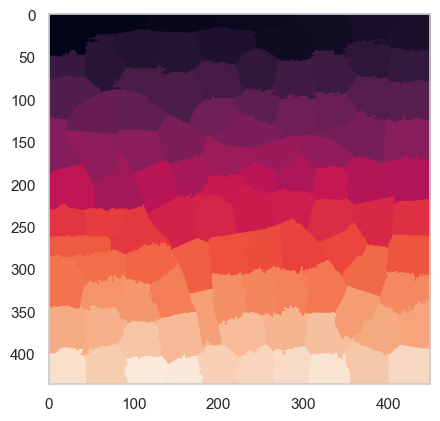

In [45]:
# segmentation for horse n. 125 
plt.imshow(segmentation_results[124][0][0])
plt.grid(False)

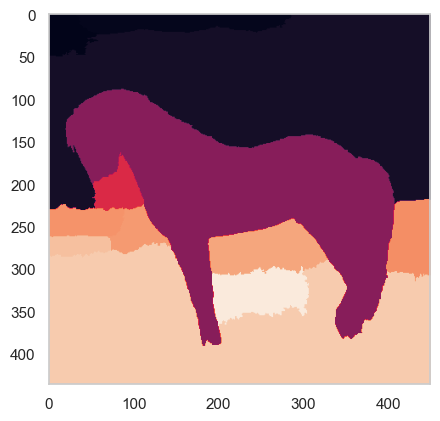

In [47]:
# cut for horse n. 125
plt.imshow(segmentation_results[124][0][1])
plt.grid(False)

In [48]:
# compute ssim score using threshold_mean/2 for all the images
ssim = []

for i in range(len(images)):
    ncolored = color.label2rgb(segmentation_results[i][0][0], images[i], kind='avg')
    gray_image = color.rgb2gray(ncolored)
    thresh = threshold_mean(gray_image)/2
    thresh_image = gray_image > thresh
    ssim_score = max(
        structural_similarity(thresh_image, masks[i], data_range=1),
        structural_similarity(1-thresh_image, masks[i], data_range=1)
        )
    ssim.append(ssim_score)

In [49]:
# print the mean, the lowest, and the highest ssim scores
print(f'Mean SSIM score: {np.mean(ssim)}')
print(f'Lowest SSIM score: {min(ssim)}')
print(f'Highest SSIM score: {max(ssim)}')

Mean SSIM score: 0.7138508469085032
Lowest SSIM score: 0.40055811889385706
Highest SSIM score: 0.9521664271587108


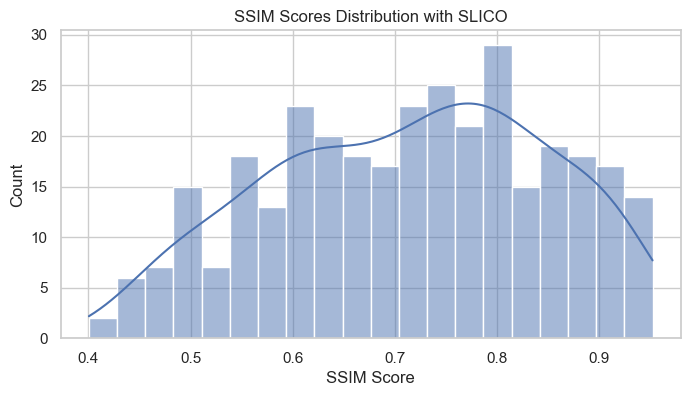

In [51]:
# plot the distribution of ssim scores with seaborn
plt.figure(figsize=(8,4))
sns.histplot(ssim, kde=True, bins=20)
plt.title('SSIM Scores Distribution with SLICO')
plt.xlabel('SSIM Score')
plt.ylabel('Count')
plt.show()

We can see that the results obtained are pretty similar to the ones of the configuration chosen with the grid search.

In [52]:
# indexes of the two lowest and two highest ssim scores
copy_ssim = ssim.copy()
copy_ssim.sort()
lowest = copy_ssim[:2]
highest = copy_ssim[-2:]

ssim.index(lowest[0]), ssim.index(lowest[1]), ssim.index(highest[0]), ssim.index(highest[1])

(305, 11, 122, 295)

Notice that both algorithms have horse 11 among the worst, and horse 295 between the best. 

## Personal Considerations

The task addressed presents various aspects to reflect on: numerous hyperparameters to manage, different metrics for evaluation, and diversity of images in the dataset used.

Starting from the choice of the parameter configuration, I had to limit the parameters to focus on and also their ranges. Some combinations of parameters resulted in error on some images, so I had to eliminate them from the grid search; for example: `compactness`=5, `sigma`=1, and `n_segments`=500. The reason the error occurred was that on some images the segmentation only produced one pixel, so it was not possible to use `graph.cut_normalized`.

In the grid search process I also computed the IoU and SSIM scores, which gave pretty different results. In fact, IoU measures the overlap between the predicted and truth masks, while SSIM considers how similar the two masks are with respect to luminance, constrast, and structure. Given that the choice of the model is based on this result, it is certainly important to think about which aspect to favor and, therefore, the most appropriate metric for the situation.

Looking at the horses that performed badly and well we can also make some considerations on in which cases the procedure is valid and which are its weak aspects. The two horses that performed badly present many shadows (in one case) and a patchy coat (in the other case); therefore, there were dark areas both in the foreground and in the background. On the other hand, the good ones were black with a monochrome (light) background, so the algorithm easily captured the silhouette of the horses.

Finally, having rather different images in the dataset in terms of brightness and chromatic range, the choice of the threshold is certainly a delicate phase. However, having to choose a strategy, it is not surprising that in several cases the SSIM is low. This variety was also an obstacle for the grid search because, as already mentioned, some configurations failed on certain instances, so I had to look for something that worked for all images. 